In [1]:
# Librerias necesarias
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import plotly.graph_objects as go
import plotly.express as px

# Configuracion de pandas para que no bloque asignaciones masivas
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_excel("../data/Online_Retail_Limpia.xlsx")
df.head()

,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice,Amount_Spent,CustomerID,Country,Month,Year,Quarter,Semana,DiaSemana,Dia,yearmonth
0,536365,2010-12-01 08:26:00,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,15.30,17850,United Kingdom,12,2010,4,48,2,1,201012
1,536365,2010-12-01 08:26:00,71053,WHITE METAL LANTERN,6,3.39,20.34,17850,United Kingdom,12,2010,4,48,2,1,201012
2,536365,2010-12-01 08:26:00,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,22.00,17850,United Kingdom,12,2010,4,48,2,1,201012
3,536365,2010-12-01 08:26:00,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,20.34,17850,United Kingdom,12,2010,4,48,2,1,201012
4,536365,2010-12-01 08:26:00,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,20.34,17850,United Kingdom,12,2010,4,48,2,1,201012


In [57]:
df.describe()

,Quantity,UnitPrice,Amount_Spent,CustomerID,Month,Year,Quarter,Semana,DiaSemana,Dia,yearmonth
count,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,20.401854,15287.690570,7.605947,2010.934002,2.854160,30.936184,2.606402,15.036128,201101.006123
std,248.693370,69.315162,427.591718,1713.600303,3.418942,0.248279,1.122363,14.765548,1.921907,8.653730,23.877089
min,-80995.000000,0.000000,-168469.600000,12346.000000,1.000000,2010.000000,1.000000,1.000000,0.000000,1.000000,201012.000000
25%,2.000000,1.250000,4.200000,13953.000000,5.000000,2011.000000,2.000000,19.000000,1.000000,7.000000,201104.000000
50%,5.000000,1.950000,11.100000,15152.000000,8.000000,2011.000000,3.000000,34.000000,2.000000,15.000000,201107.000000
75%,12.000000,3.750000,19.500000,16791.000000,11.000000,2011.000000,4.000000,44.000000,4.000000,22.000000,201110.000000
max,80995.000000,38970.000000,168469.600000,18287.000000,12.000000,2011.000000,4.000000,51.000000,6.000000,31.000000,201112.000000


In [58]:
print("===================================================================")
print("Tamaño del dataframe:")
print(df.shape)
print("===================================================================")
print("Tipo de variable de las columnas:")
print(df.dtypes)
print("===================================================================")
print("Cantidad de valores nulos por columna:")
print(df.isna().sum())
print("===================================================================")

Tamaño del dataframe:
(406829, 16)
Tipo de variable de las columnas:
InvoiceNo               object
InvoiceDate     datetime64[ns]
StockCode               object
Description             object
Quantity                 int64
UnitPrice              float64
Amount_Spent           float64
CustomerID               int64
Country                 object
Month                    int64
Year                     int64
Quarter                  int64
Semana                   int64
DiaSemana                int64
Dia                      int64
yearmonth                int64
dtype: object
Cantidad de valores nulos por columna:
InvoiceNo       0
InvoiceDate     0
StockCode       0
Description     0
Quantity        0
UnitPrice       0
Amount_Spent    0
CustomerID      0
Country         0
Month           0
Year            0
Quarter         0
Semana          0
DiaSemana       0
Dia             0
yearmonth       0
dtype: int64


## Información relevante de la base de datos
Según la fuente de información que publicó dicha base de datos (https://archive.ics.uci.edu/ml/datasets/online+retail), esta corresponde  aun conjunto de transacciones ocurridas entre el 01-12-2010 y 09-12-2011 para un comercio minorista en línea con sede en Reino Unido. <br>
La base de datos está compuesta por las siguientes columnas:
- InvoiceNo: número de factura. Es un valor numérico de 6 dígitos asignado de forma exclusiva para cada transacción. Si el código comienza con una letra "c", corresponde a una cancelación.
- StockCode: código de producto o artículo. Es un valor numérico de 5 dígitos asociado a cada producto.
- Description: descripción del producto.
- Quantity: corresponde a un valor númerico, que representa la cantidad de cada producto o artículo por transacción.
- InvoiceDate: fecha y hora de la factura. 
- UnitPrice: valor numérico correspondiente al precio unitarioen libras esterlinas.
- CustomerID: valor numérico de 5 dígitos asignado de forma exclusiva a cada cliente.
- Country: nombre del país. <br>

A parte de estos campos que trae el dataset o base de datos, se añadieron otras columnas, las cuales son:
- Amount_Spent: total gastado, el producto entre el precio unitario y la cantidad.
- Month: el mes de la factura.
- Year: el año de la factura.
- Quarter: qué cuarto del año corresponde.
- Semana: número de la semana del año que corresponde.
- DiaSemana: día de la semana (Lunes = 0, Martes = 1, ..., Sábado = 5 y Domingo = 6).
- Dia: número del día del mes.
- yearmonth: concatenación de número de mes y año.

<hr>

## Introducción al análisis de variables
A continuación se procede a analizar las variables de la base de datos por separado, para identificar ciertos grupos de interés que posteriormente serán de interés en los análisis más detallados.

<hr>

## InvoiceNo
Número de factura. Es un valor numérico de 6 dígitos asignado de forma exclusiva para cada transacción. Si el código comienza con una letra "c", corresponde a una cancelación.

In [5]:
data = {
    "Estado": ["Cancelaciones", "No cancelaciones"],
    "Cantidad": [df[(df.InvoiceNo.str.contains("C") == True) & ~((df.StockCode == "D") | (df.StockCode == "M"))].shape[0], 
                 df[~(df.InvoiceNo.str.contains("C") == True)].shape[0]]
}

df_invoiceNo = pd.DataFrame(data = data)
df_invoiceNo

,Estado,Cantidad
0,Cancelaciones,8653
1,No cancelaciones,397924


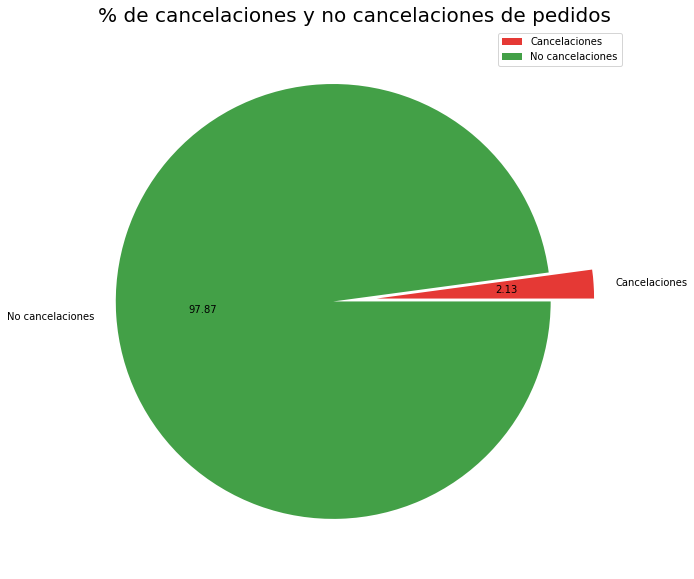

In [78]:
plt.figure(figsize=(18,10))
explode = [0.1, 0.1]
color = ["#E53935", "#43A047"]
plt.pie(df_invoiceNo["Cantidad"], labels= df_invoiceNo["Estado"], autopct="%.2f", explode=explode, colors = color)
plt.legend(loc = "best")
plt.title("% de cancelaciones y no cancelaciones de pedidos", fontsize = 20)
plt.show()

In [8]:
# Se sacan los descuentos y "manuales"
df_cancelados = df[(df.InvoiceNo.str.contains("C") == True) & ~((df.StockCode == "D") | (df.StockCode == "M"))]
df_cancelados

,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice,Amount_Spent,CustomerID,Country,Month,Year,Quarter,Semana,DiaSemana,Dia,yearmonth
154,C536383,2010-12-01 09:49:00,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,-4.65,15311,United Kingdom,12,2010,4,48,2,1,201012
235,C536391,2010-12-01 10:24:00,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,-19.80,17548,United Kingdom,12,2010,4,48,2,1,201012
236,C536391,2010-12-01 10:24:00,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,-6.96,17548,United Kingdom,12,2010,4,48,2,1,201012
237,C536391,2010-12-01 10:24:00,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,-6.96,17548,United Kingdom,12,2010,4,48,2,1,201012
238,C536391,2010-12-01 10:24:00,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,0.29,-6.96,17548,United Kingdom,12,2010,4,48,2,1,201012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406376,C581490,2011-12-09 09:57:00,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,1.95,-23.40,14397,United Kingdom,12,2011,4,49,4,9,201112
406377,C581490,2011-12-09 09:57:00,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,0.83,-9.13,14397,United Kingdom,12,2011,4,49,4,9,201112
406635,C581568,2011-12-09 11:57:00,21258,VICTORIAN SEWING BOX LARGE,-5,10.95,-54.75,15311,United Kingdom,12,2011,4,49,4,9,201112
406636,C581569,2011-12-09 11:58:00,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,1.25,-1.25,17315,United Kingdom,12,2011,4,49,4,9,201112


In [25]:
df_productosC = df_cancelados.groupby("Description").agg({
    "StockCode": "count",
    "Quantity": "sum",
    "Amount_Spent": "sum"
})
# Se convierten los campos negativos a positivos
df_productosC["Quantity"] = df_productosC["Quantity"].apply(lambda x: -x)
df_productosC["Amount_Spent"] = df_productosC["Amount_Spent"].apply(lambda x: -x)

# Se seleccionan las columnas de interes
df_productosSC = df_productosC[["StockCode"]].sort_values("StockCode", ascending = False).head(10)
df_productosQ = df_productosC[["Quantity"]].sort_values("Quantity", ascending = False).head(10)
df_productosAS = df_productosC[["Amount_Spent"]].sort_values("Amount_Spent", ascending = False).head(10)

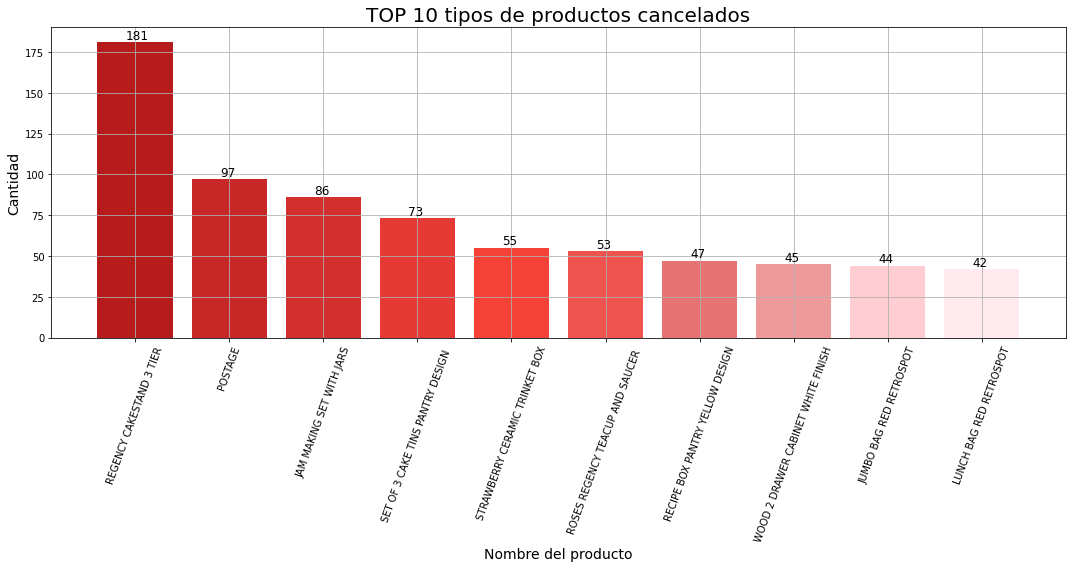

In [82]:
color_palet = ["#B71C1C", "#C62828", "#D32F2F", "#E53935", "#F44336", "#EF5350", "#E57373", "#EF9A9A", "#FFCDD2", "#FFEBEE"]
plt.figure(figsize=(15,8))
plt.grid()
plt.bar(df_productosSC.index, df_productosSC["StockCode"], color = color_palet)
plt.xticks(rotation = 70)
plt.xlabel("Nombre del producto", fontsize = 14)
plt.ylabel("Cantidad", fontsize = 14)
plt.title("TOP 10 tipos de productos cancelados", fontsize = 20)
# Se muestra la cantidad por cada barra
for index,data in enumerate(df_productosSC["StockCode"]):
    plt.text(x = index-0.098, y = data + 2, s = f"{data}", fontdict=dict(fontsize = 12))
plt.tight_layout()
plt.show()

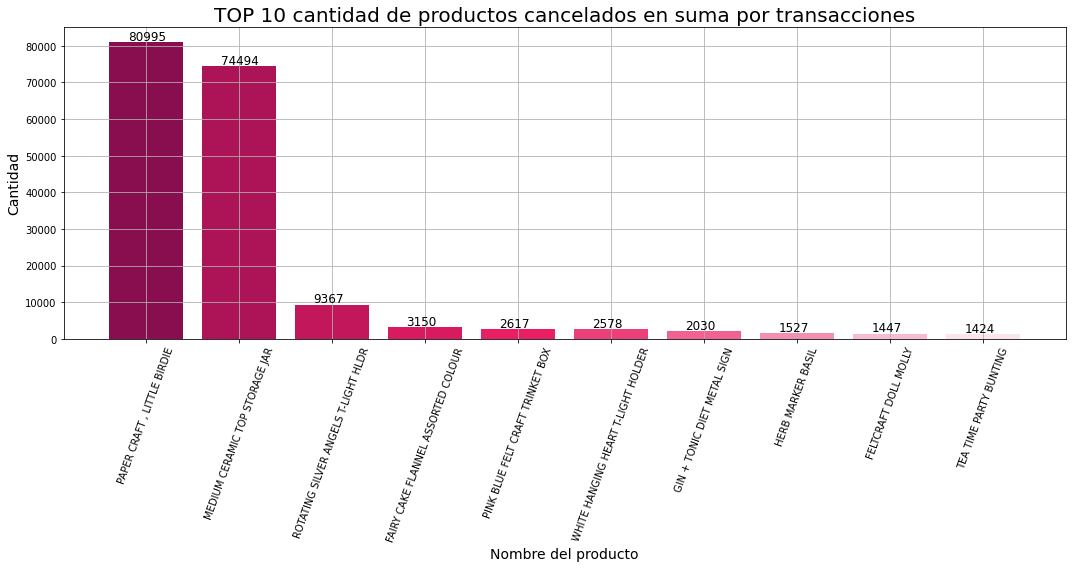

In [84]:
color_palet = ["#880E4F", "#AD1457", "#C2185B", "#D81B60", "#E91E63", "#EC407A", "#F06292", "#F48FB1", "#F8BBD0", "#FCE4EC"]
plt.figure(figsize=(15,8))
plt.grid()
plt.bar(df_productosQ.index, df_productosQ["Quantity"], color = color_palet)
plt.xticks(rotation = 70)
plt.xlabel("Nombre del producto", fontsize = 14)
plt.ylabel("Cantidad", fontsize = 14)
plt.title("TOP 10 cantidad de productos cancelados en suma por transacciones", fontsize = 20)
# Se muestra la cantidad por cada barra
for index,data in enumerate(df_productosQ["Quantity"]):
    plt.text(x = index-0.2, y = data + 500, s = f"{data}", fontdict=dict(fontsize = 12))
plt.tight_layout()
plt.show()

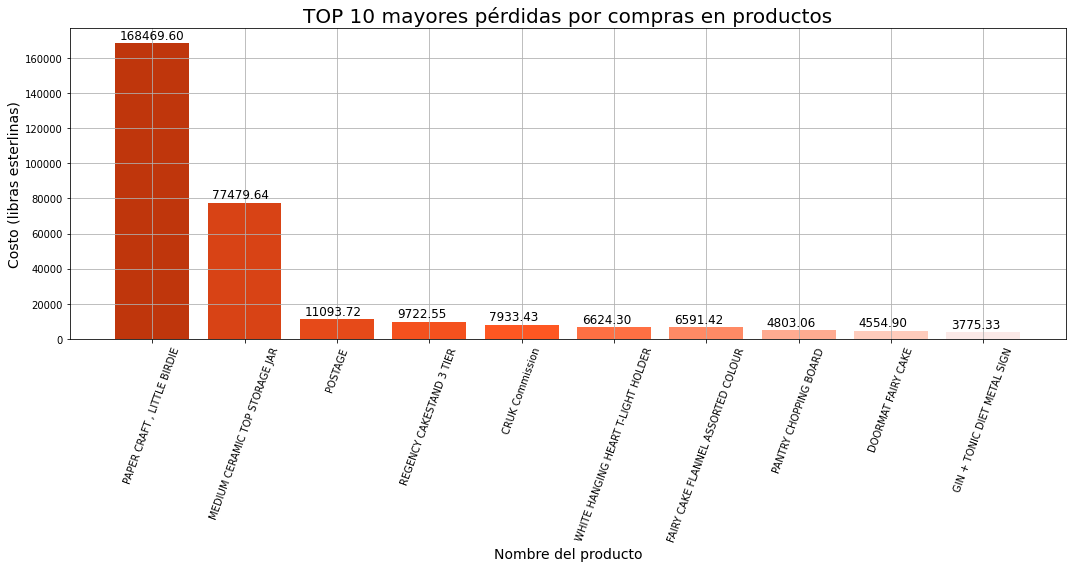

In [85]:
color_palet = ["#BF360C", "#D84315", "#E64A19", "#F4511E", "#FF5722", "#FF7043", "#FF8A65", "#FFAB91", "#FFCCBC", "#FBE9E7"]
plt.figure(figsize=(15,8))
plt.grid()
plt.bar(df_productosAS.index, df_productosAS["Amount_Spent"], color = color_palet)
plt.xticks(rotation = 70)
plt.xlabel("Nombre del producto", fontsize = 14)
plt.ylabel("Costo (libras esterlinas)", fontsize = 14)
plt.title("TOP 10 mayores pérdidas por compras en productos", fontsize = 20)
# Se muestra la cantidad por cada barra
for index,data in enumerate(df_productosAS["Amount_Spent"]):
    plt.text(x = index-0.35, y = data + 2400, s = "{0:.2f}".format(data), fontdict=dict(fontsize = 12))
plt.tight_layout()
plt.show()

In [103]:
df_paisesC = df_cancelados.groupby("Country").agg({
    "Description": "count"
})
df_paisesC = df_paisesC.sort_values("Description", ascending = False).head(10)
df_paisesC

,Description
Country,
United Kingdom,7325
Germany,446
EIRE,243
France,145
USA,112
Australia,74
Spain,45
Italy,43
Belgium,38


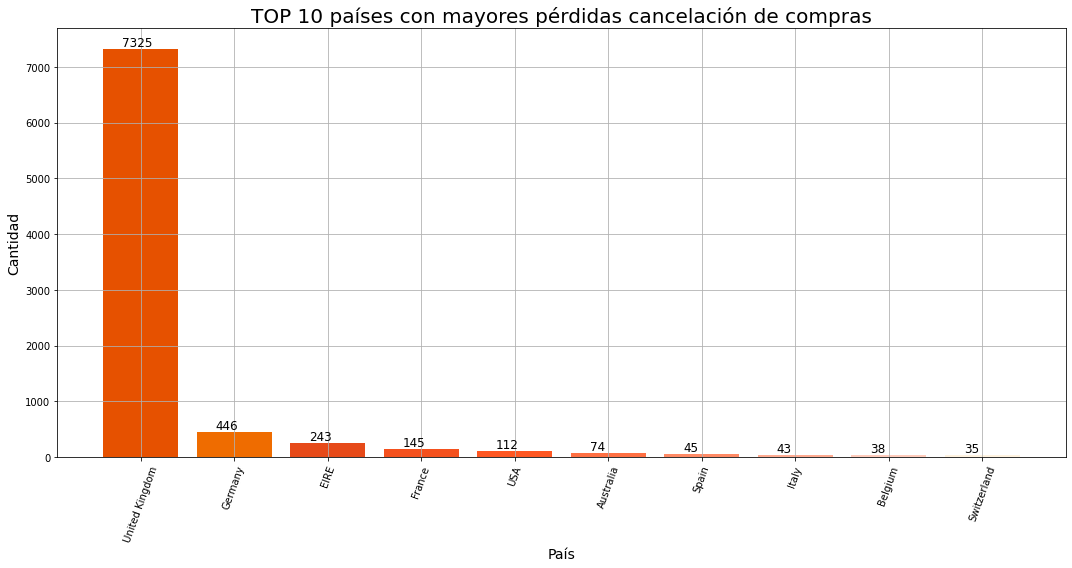

In [116]:
color_palet = ["#E65100", "#EF6C00", "#E64A19", "#F4511E", "#FF5722", "#FF7043", "#FF8A65", "#FFAB91", "#FFCCBC", "#FFF3E0"]
plt.figure(figsize=(15,8))
plt.grid()
plt.bar(df_paisesC.index, df_paisesC["Description"], color = color_palet)
plt.xticks(rotation = 70)
plt.xlabel("País", fontsize = 14)
plt.ylabel("Cantidad", fontsize = 14)
plt.title("TOP 10 países con mayores pérdidas cancelación de compras", fontsize = 20)
# Se muestra la cantidad por cada barra
for index,data in enumerate(df_paisesC["Description"]):
    plt.text(x = index-0.2, y = data + 50, s = data, fontdict=dict(fontsize = 12))
plt.tight_layout()
plt.show()